# Panel 1

### Packages

In [1]:
%matplotlib inline
#
from lrgsglib.config.plotlib import scheme_Lattice2DSquared
from lrgsglib.config.utils import extract_and_sort_values
from lrgsglib.core import *
#
move_to_rootf(print_tf=True)
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
subdatapath = os.path.join('plot', 'paper', 'panel_1/')
fullpath = os.path.join("data", subdatapath)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


### Fig. a (lattice)

In [2]:
side = 7
fig, ax = plt.subplots(figsize=(8, 8))
#
ax.axis("off")
ax.set_aspect('equal')
#
scheme_Lattice2DSquared(ax, side1=side, pec=cred, cpec=cblu, mode='rand')
#
fig.savefig(f"{fullpath}disordered_grid{side}.pdf",
    bbox_inches="tight", pad_inches=-0.5,
)
plt.close('all')

### Fig. b ($C$ specific heat)

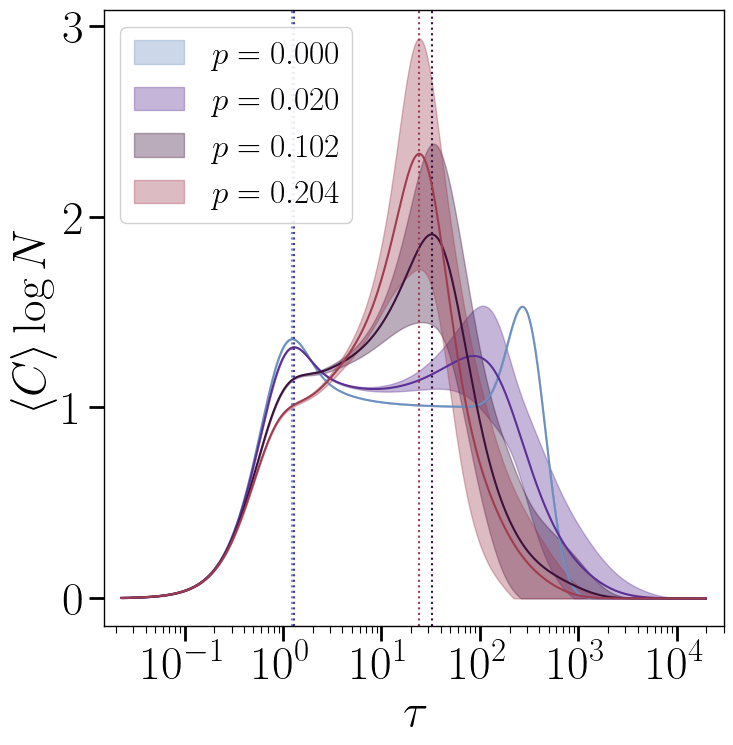

In [4]:
side = 64
number_of_averages = 256
out_suffix = ""
fname = "avgC_"
plist = [0, 0.0204, 0.102, 0.204]#0.408
#
# Choose a colormap
cmap = plt.cm.twilight
colors = cmap(np.linspace(0.2, 0.7, len(plist)))
# Set these colors as the default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
#
fig, ax = plt.subplots(figsize=(8, 8))
#
for p in plist:
    sqlatt = Lattice2D(side1=side, pflip=p, sgpath=subdatapath)
    sla = SignedLaplacianAnalysis(sqlatt, initspect=False)
    #
    fsfx = f"{number_of_averages}_p={sqlatt.pflip:.3g}_{out_suffix}"
    file_path = f"{sqlatt.lrgsgpath}{fname}{fsfx}.npz"
    meanfname = f"{sqlatt.lrgsgpath}meancurve_{fname}{fsfx}.npy"
    stdfname = f"{sqlatt.lrgsgpath}stddev_{fname}{fsfx}.npy"
    #
    if os.path.exists(meanfname) and os.path.exists(stdfname):
        mean_curve = np.load(meanfname)
        std_dev = np.load(stdfname)
    else:
        #
        ld_f = np.load(file_path)
        ld_arr = [
            ld_f[f"arr_{i}"] for i in range(number_of_averages)
        ]
        ld_f.close()
        mean_curve = np.mean(ld_arr, axis=0)
        std_dev = np.std(ld_arr, axis=0)
        with open(meanfname, 'wb') as f:
            np.save(f, mean_curve)
        with open(stdfname, 'wb') as f:
            np.save(f, std_dev)
    mean_curve = gaussian_filter1d(mean_curve[50:-100], sigma=3)  # sigma can be adjusted based on data characteristics
    std_dev = std_dev[50:-100]
    tau = sla.tTsC[50:-100]
    (line,) = ax.plot(tau, mean_curve)
    # for imax in argrelextrema(mean_curve, np.greater)[0]:
    imax = argrelextrema(mean_curve, np.greater)[0][0]
    ax.axvline(tau[imax], ls=':', color=line.get_color())
    ax.fill_between(
        tau,
        np.maximum((mean_curve - std_dev), 0),
        (mean_curve + std_dev),
        color=line.get_color(),
        alpha=0.35,
        zorder=line.get_zorder() - 1,
        label=rf"$p={p:.3f}$",
    )

ax.set_xscale("log")
ax.set_ylabel(r"$\avg{C}\log N$")
ax.set_xlabel(r"$\tau$")
ax.legend(fontsize=24, loc="upper left")
ax.xaxis.get_major_locator().set_params(numticks=8)
ax.xaxis.get_minor_locator().set_params(
    numticks=10, subs=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)
ax.set_xlim([1.5e-2, 3e4])
fig.savefig(
    f"{fullpath}avgC{side}_{number_of_averages}.pdf",
    bbox_inches="tight"
)
plt.close('all')

### Fig. c ($\tau_{\max}^{(0)}$ distribution)

In [ ]:
side = 45
navg = 20000
sqlatt = Lattice2D(side1=side, sgpath="plot/paper/panel_1/")
#
plist = extract_and_sort_values(sqlatt.lrgsgpath, search_pattern=r"p=([\d.]+)", sort=True)
tll = 0.098
tul = 0.105
#
to_slice_1 = [1, 28]
slice_1 = first_index_changing_condition(plist < tll)
slice_2 = first_index_changing_condition(plist < tul)
slice_2_to_end = len(plist)-slice_2
slice_full = np.r_[0,
                   slice_1:slice_2, 
                   slice_2:len(plist):slice_2_to_end//4]
plist = plist[slice_full]
#
plistmid = plist[(tll < plist) & (plist < tul)]
plistmid_len = len(plistmid)
plisteff_len = len(plist)-plistmid_len

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

#
cmap = plt.cm.twilight
cmap_val = cmap(np.linspace(0.2, 0.8, len(plist)))
custom_cmap = LinearSegmentedColormap.from_list("custom_twilight", cmap_val)
cmap_tra = create_custom_colormap(c1="#02a618", c2="#00eeff")
cmap_nrm = Normalize(vmin=min(plist), vmax=max(plist))
#
ax.set_ylabel(r"$-\log[P(\tau_{\max}^{(0)})]$")
ax.set_xlabel(r"$\tau_{\max}^{(0)}$")
#
cntr = 1
for i, p in enumerate(plist):
    taumax = np.fromfile(f"{sqlatt.lrgsgpath}tau_max0_avg{navg}_p={p:.3g}.bin")
    bin_centers, hist, bw = log_binning(taumax, 25)
    #
    pch = pchip(bin_centers, hist)
    xx = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    total_area = np.trapz(pch(xx), x=xx)
    y_normalized = pch(xx) / total_area
    energy = -np.log(y_normalized)
    energy[energy == np.inf] = 100
    #
    if tll < p < tul:
        kwargs = {'color': cmap_tra(cntr/plistmid_len), 'zorder': 100, 
                  'label': fr'${p:.3g}$', 'lw': 2}
        cntr += 1
        ax.axvline(xx[np.argmin(energy[~np.isnan(energy)])], ls=':', lw=2, color=cmap_tra(cntr/plistmid_len), zorder=200)
    else:
        kwargs = {'color': cmap_val[i], 'zorder': i, 
                  'label': '', 'lw': 2}
        ax.axvline(xx[np.argmin(energy[~np.isnan(energy)])], ls=':', lw=2, color=cmap_val[i], zorder=100)
    #
    ax.plot(xx, energy, '-', **kwargs)
ax.set_ybound(lower=-4, upper=20)
ax.set_xscale('log')
#
cbar_ax = fig.add_axes([0.2, 0.89, 0.7, 0.04])
clb = fig.colorbar(ScalarMappable(norm=cmap_nrm, cmap=custom_cmap), cax=cbar_ax, orientation='horizontal')
# clb.ax.set_title(r'$p$', pad=10)
for i, p in enumerate(plist[(tll < plist) & (tul > plist)]):
    cbar_ax.plot(p, 0.5, 'H', mec='k', ms=15, 
                mfc = set_alpha_torgb(cmap_tra(i/plistmid_len), 0.8))
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.set_ylabel(r'$p$', rotation=360, labelpad=25)
ylabel = cbar_ax.yaxis.get_label()
x, y = ylabel.get_position()
ylabel.set_position((x, y - .6))  # This moves the label up

cbar_ax.tick_params(axis='x', which='both', length=5, labelsize=22) 

#
fig.savefig(f'{fullpath}squared_lattice_taumaxdistri.pdf', 
            bbox_inches='tight')
plt.close('all')